## Table des matières

- [Mission 0](#chapitre_0)
- [Mission 1](#chapitre_1)
    - [Analyse de l'éboulis des valeurs propres](#chapitre_1_1)
    - [Représentation des variables par le cercle des corrélations](#chapitre_1_2)
    - [Visualisation dans le premier plan factoriel obtenu par ACP](#chapitre_1_3)
- [Mission 2](#chapitre_2)
- [Mission 3](#chapitre_3)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import decomposition, preprocessing

In [2]:
data = pd.read_csv('notes.csv')

data.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84


<a id="chapitre_0"></a>
## <span style="color: #030aa4">Mission 0</span>

In [3]:
dataQuantitative = data.drop(columns= 'is_genuine')

for x in dataQuantitative.columns :
    print("-"*60)
    print("Variable",x)
    print(" ")
    print("Indicateurs de tendance centrale et de dispersion :")
    print("moy:\n",dataQuantitative[x].mean())
    print("med:\n",dataQuantitative[x].median())
    print("mod:\n",dataQuantitative[x].mode()[0])
    print(" ")
    mode = dataQuantitative[x].mode()[0]
    median = dataQuantitative[x].median()
    mean = dataQuantitative[x].mean()
    if mode == median == mean :
        print("La distribution de la variable", x, "est symétrique.")
    elif mode < median < mean :
        print("La distribution de la variable", x, "est étalée à droite.")
    elif mode > median > mean :
        print("La distribution de la variable", x, "est étalée à gauche.")
    else :
        print("Il n'est pas possible de déduire la forme de la distribution avec les indicateurs de tendance centrale.")
    print(" ")
    print("Analyse de concentration :")
    print(" ")
    print("var:\n",dataQuantitative[x].var(ddof=0))
    print("ect:\n",dataQuantitative[x].std(ddof=0))
    print("skw:\n",dataQuantitative[x].skew())
    print("kur:\n",dataQuantitative[x].kurtosis())
    print(" ")
    skewness = dataQuantitative[x].skew()
    if skewness < 0:
        print("Le skewness empirique est égal à",skewness,".")
        print("La distribution est étalée à gauche.")
    elif skewness > 0:
        print("Le skewness empirique est égal à",skewness,".")
        print("La distribution est étalée à droite.")
    else:
        print("Le skewness empirique est égal à",skewness,".")
        print("La distribution est symétrique.")
    kurtosis = dataQuantitative[x].kurtosis()
    if kurtosis < 0:
        print("Le kurtosis empirique est égal à",kurtosis,".")
        print("La distribution est plus aplatie qu'une distribution normale.")
        print("Les observations sont moins concentrées.")
    elif kurtosis > 0:
        print("Le kurtosis empirique est égal à",kurtosis,".")
        print("La distribution est moins aplatie qu'une distribution normale.")
        print("Les observations sont plus concentrées.")
    else:
        print("Le kurtosis empirique est égal à",kurtosis,".")
        print("La distribution a le même aplatissement qu'une distribution normale.")

------------------------------------------------------------
Variable diagonal
 
Indicateurs de tendance centrale et de dispersion :
moy:
 171.94058823529414
med:
 171.945
mod:
 172.1
 
La distribution de la variable diagonal est étalée à gauche.
 
Analyse de concentration :
 
var:
 0.09294435986159198
ect:
 0.3048677743901313
skw:
 0.19616651211086614
kur:
 0.5868437884868345
 
Le skewness empirique est égal à 0.19616651211086614 .
La distribution est étalée à droite.
Le kurtosis empirique est égal à 0.5868437884868345 .
La distribution est moins aplatie qu'une distribution normale.
Les observations sont plus concentrées.
------------------------------------------------------------
Variable height_left
 
Indicateurs de tendance centrale et de dispersion :
moy:
 104.0663529411764
med:
 104.055
mod:
 104.17
 
Il n'est pas possible de déduire la forme de la distribution avec les indicateurs de tendance centrale.
 
Analyse de concentration :
 
var:
 0.08839140484429073
ect:
 0.29730692027

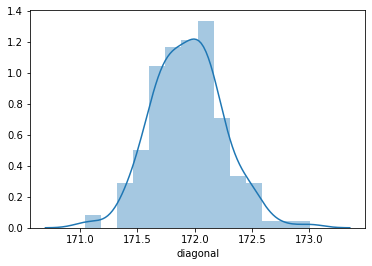

In [4]:
ax=sns.distplot(data['diagonal'])

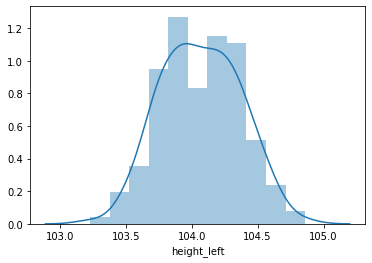

In [5]:
ax=sns.distplot(data['height_left'])

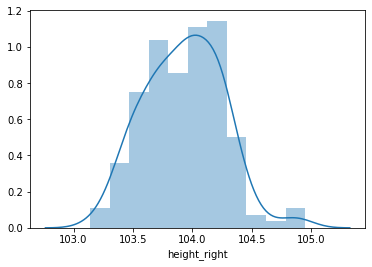

In [6]:
ax=sns.distplot(data['height_right'])

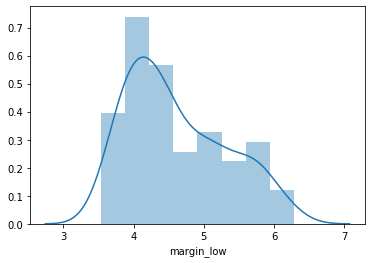

In [7]:
ax=sns.distplot(data['margin_low'])

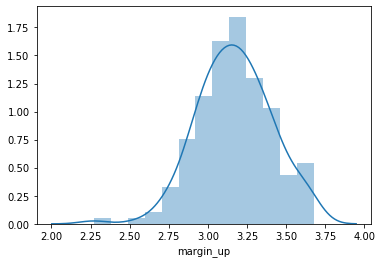

In [8]:
ax=sns.distplot(data['margin_up'])

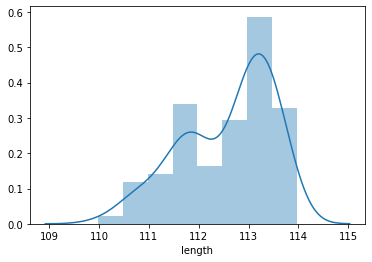

In [9]:
ax=sns.distplot(data['length'])

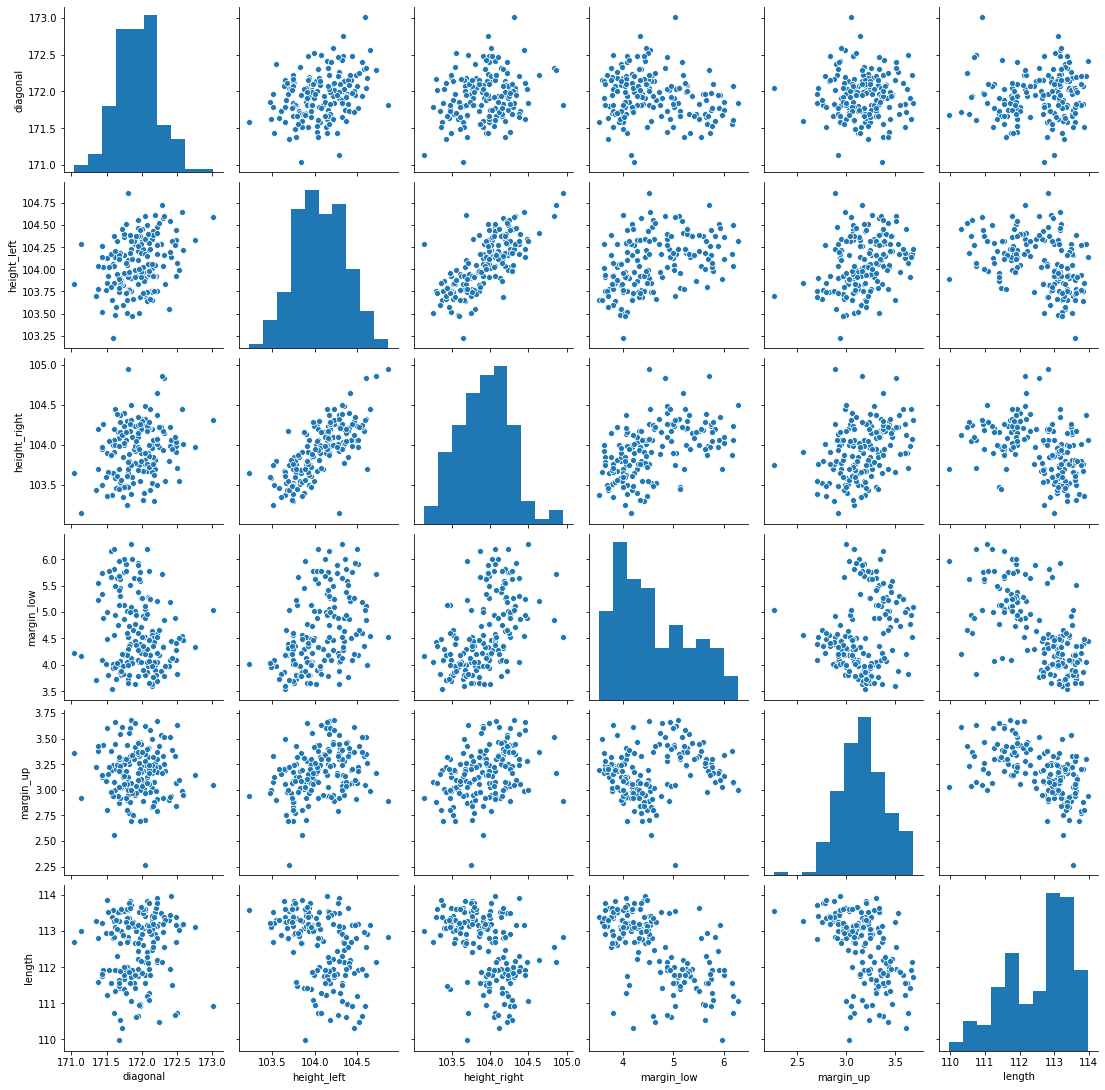

In [10]:
sns.pairplot(dataQuantitative)

<a id="chapitre_1"></a>
## <span style="color: #030aa4">Mission 1</span>

<a id="chapitre_1_1"></a>
### <span style="color: #a40334">Analyse de l'éboulis des valeurs propres</span>

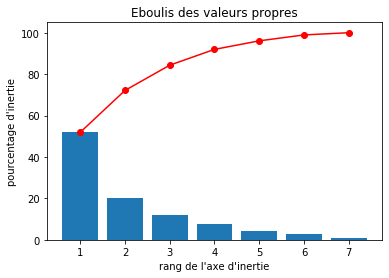

In [11]:
X = data.values

# Centrage et standardization
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Choix du nombre de composantes à calculer
n_comp = 7

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c='red',marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
display_scree_plot(pca)

**Selon le critère de Kaiser, on ne retient que les deux premiers axes d'inertie.**

<a id="chapitre_1_2"></a>
### <span style="color: #a40334">Représentation des variables par le cercle des corrélations</span>

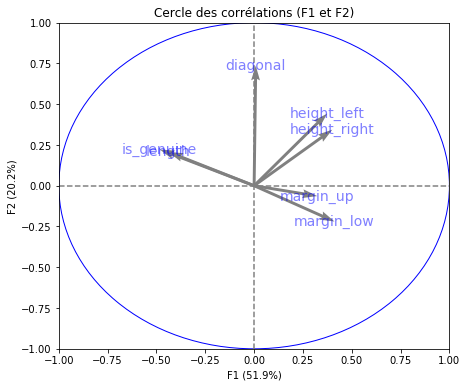

In [12]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.savefig("Cercle des corrélations.png")
            plt.show(block=False)
        

    
# choix du nombre de composantes à calculer
n_comp = 7

# sélection des colonnes à prendre en compte dans l'ACP
data_pca = data[['is_genuine',
                 'diagonal',
                 'height_left',
                 'height_right',
                 'margin_low',
                'margin_up',
                 'length']]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = data.index
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

<a id="chapitre_1_3"></a>
### <span style="color: #a40334">Visualisation dans le premier plan factoriel obtenu par ACP</span>

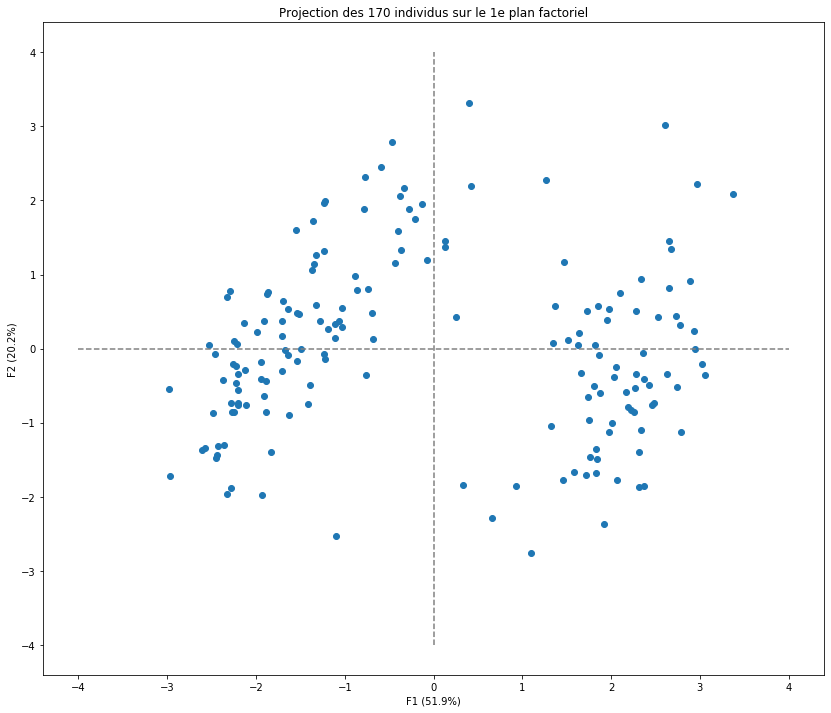

In [13]:
d1 = 0
d2 = 1

# Coordonnées F1, F2 de chaque point 

X_scaled = preprocessing.StandardScaler().fit_transform(data.values)
pca = decomposition.PCA(n_components=2)
X_projected = pca.fit_transform(X_scaled)
dataCP= pd.DataFrame(X_projected, index=data.index, columns = ["F"+str(i+1) for i in range(2)])

# Nuage de points :

fig = plt.figure(figsize=(14,12))
scatter = plt.scatter(dataCP['F1'], dataCP['F2'])

# Affichage des axes
plt.plot([-4, 4], [0, 0], color = 'grey', ls='--')
plt.plot([0, 0], [-4, 4] , color = 'grey', ls='--')

# Nom des axes
plt.xlabel("F{} ({}%)".format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel("F{} ({}%)".format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
#plt.legend(handles = scatter.legend_elements()[0], labels = classes)
#plt.savefig("Projection des 165 individus sur le 1er plan factoriel, méthode dendrogramme")
plt.show(block=False)

<a id="chapitre_3"></a>
## <span style="color: #030aa4">Mission 3</span>

<a id="chapitre_3_1"></a>
### <span style="color: #a40334">Modélisation des données à l'aide d'une régression logistique</span>

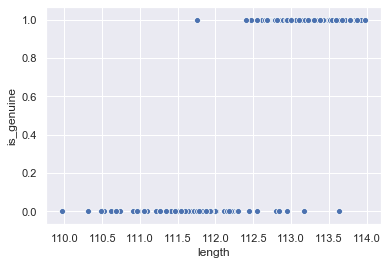

In [14]:
sns.set()

ax = sns.scatterplot(x="length", y="is_genuine", data=data)

#### Proportion de vrais billets selon les classes de longueur

In [15]:
# Conversion des données de la colonne "is_genuine" True et False en 1 et 0 :
data["is_genuine"] = data["is_genuine"].view('i1')

In [16]:
data['cl_length'] = pd.cut(data['length'], bins = np.arange(110, 114, 0.5), right=False)
prop = pd.crosstab(data['cl_length'], data['is_genuine'], normalize='index')
prop_genuine = pd.DataFrame(data = {'length': np.concatenate((np.array([110]), 
                                                       np.repeat(np.arange(110.5,113.5,0.5), repeats=2), 
                                                       np.array([113.5])), axis=0),
                                'prop_genuine': np.repeat(prop.loc[:,1].values, repeats=2)})

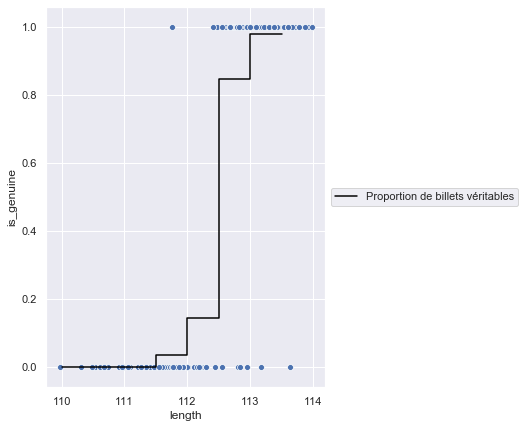

In [17]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=data)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de billets véritables')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Régression logistique

In [18]:
reg_log1 = smf.glm('is_genuine ~ length', data=data, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31.836
Date:                Thu, 13 Aug 2020   Deviance:                       63.672
Time:                        16:21:33   Pearson chi2:                     371.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -549.0766     87.271     -6.292      0.0

On obtient les paramètres estimés : $\hat{\beta}_{1}=−549.07$ et $\hat{\beta}_{2}=4.88$. Enregistrons-les :

In [19]:
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

Dans le but de tracer la courbe logistique entre les abscisses $x=110$ et $x=114$, on définit une séquence de 110 à 114 par pas de 500, puis on la place dans la variable x. On calcule ensuite les ordonnées de la courbe, grâce à l'expression de la courbe en S :
<br><br><center><font size="4">$f(x) = \frac{e^{\beta_{1}+\beta_{2}x}}{1+e^{\beta_{1}+\beta_{2}x}}$</font></center>

Nous plaçons ces ordonnées dans la variable y. Enfin, avec x et y, nous créons un dataframe :

In [20]:
x = np.linspace(start=110, stop=114, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log = pd.DataFrame(data={'length': x, 'prop_genuine': y})

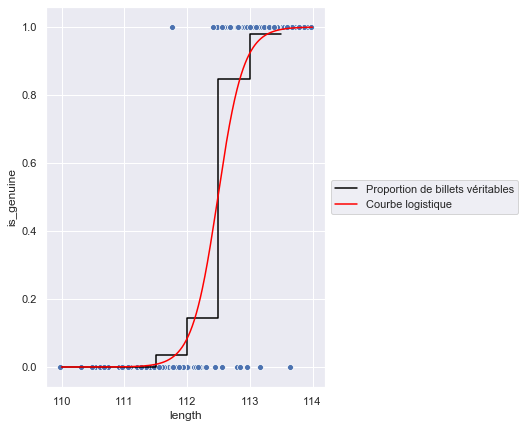

In [21]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=data)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de billets véritables')
plt.plot(reg_log['length'], reg_log['prop_genuine'], color='red', label='Courbe logistique')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()